In [2]:
import numpy as np

from ml.my_k_means import my_k_means
from models.DevelopmentSession import DevelopmentSession
from db.sqlite import SQLiteManager
from models.enums import ErrorType
from utils.plotHelper import plot_radar_node, plot_error_class, plot_radar_all_centroid_same_plot, plot_radar_all_centroid_different_plot, plot_radar_ahp
import sys
import pandas as pd

In [17]:
# * 1) Connect with Database
SQLiteManager.connect()
cur = SQLiteManager.conn
sql = 'select multiple_ses_stud.student, exams.id, sessions.date, multiple_ses_stud.cnt, results.grade, grade_sort.id as grd'
sql += ' from results, sessions, multiple_ses_stud, students, exams, grade_sort' 
sql += ' where results.grade=grade_sort.grade and exams.session=sessions.id and' 
sql += ' students.matr like multiple_ses_stud.student and exams.student=students.id and'
sql += ' results.session like sessions.date and results.student like students.matr'
sql += ' order by multiple_ses_stud.student, exams.id'

df = pd.read_sql_query(sql,SQLiteManager.conn)
print(df.shape)
print(df.head())



(605, 6)
     student    id      date  cnt  grade  grd
0  832000811   654  20180321    9  INSUF    6
1  832000811   711  20180725    9    DIS    4
2  832000811  1101  20170717    9  INSUF    6
3  A13000318   542  20181011    9    DIT    2
4  A13000318   704  20180725    9  INSUF    6


In [18]:
df['ahp'] = np.zeros(df.shape[0])-1



In [13]:
ahp_weigths = pd.read_csv("ahp_result.csv", header=None )
ahp_weigths['ahp']=ahp_weigths.iloc[:,1:9].sum(axis=1)
ahp_weigths=ahp_weigths.drop(ahp_weigths.columns[1:9], axis=1)
ahp_weigths.columns=['id','ahp']
print(ahp_weigths.head())


   id       ahp
0   8  0.028330
1  11  0.007572
2  18  0.016956
3  25  0.017713
4  27  0.030041


In [19]:

ahp_ids = ahp_weigths.iloc[:, 0].values
for i in range(df.shape[0]):
    if df.iloc[i]['id'] in ahp_ids:
        # print(df.iloc[i]['id'], ahp_weigths[ahp_weigths['id']==df.iloc[i]['id']]['ahp'])
        df.at[i,'ahp'] = ahp_weigths[ahp_weigths['id']==df.iloc[i]['id']]['ahp']
        # print(df.iloc[i])
df = df[df['ahp']>=0]
print(df.shape)
print(df.head())


(91, 7)
      student    id      date  cnt  grade  grd       ahp
10  A13000758   936  20190709    2    SUF    5  0.010900
14  A13000934   912  20181108    2  INSUF    6  0.013884
20  A13001074   605  20180613    5  INSUF    6  0.042955
47  A13001300   981  20180124    5  INSUF    6  0.024264
48  A13001300  1030  20171204    5  INSUF    6  0.003428


In [37]:
sql = 'select results.*, grade_sort.id from results, grade_sort where results.grade=grade_sort.grade and grade_sort.id <6 order by id'
results = pd.read_sql_query(sql,SQLiteManager.conn)
results['dd'] = pd.to_datetime(results['session'], format='%Y%m%d')
results = results[['student','grade','id','dd']]
results = results.sort_values(by='dd')
print(results.shape)
print(results.head())

(966, 4)
       student grade  id         dd
681  A13001381   DIS   4 2017-05-19
26   A13001427   OTT   1 2017-05-19
298  A13001357   DIT   2 2017-05-19
776  A13000360   SUF   5 2017-05-19
21   A13001397   OTT   1 2017-05-19


In [72]:
stat_array = None
df_min = df.groupby('student').agg('min').sort_values(by='student')
print(df_min.shape)


for i in range(df_min.shape[0]):
    student = df[df['student']==df_min.iloc[i].name]
    if student.shape[0] >0:
        if student.shape[0] >1:
            student['dd'] = pd.to_datetime(student['date'], format='%Y%m%d')      
            student = student.sort_values(by='dd')
        else:
            student['dd'] = pd.to_datetime(student['date'], format='%Y%m%d') 
            
        if student.iloc[0]['grd']>5:
           if student.shape[0]>1 and student.iloc[-1]['grd']<6:
              # print(student.iloc[0]['student'], student.iloc[0]['dd'], student.iloc[0]['ahp'], student.iloc[-1]['dd'], student.iloc[-1]['grd'],student.iloc[-1]['grade'])
              # print(student.iloc[0])
              if stat_array is None:
               stat_array = np.array([[student.iloc[0]['student'], student.iloc[0]['dd'], student.iloc[0]['ahp'], student.iloc[-1]['dd'], student.iloc[-1]['grd'],student.iloc[-1]['grade']]])
              else:
               stat_array = np.vstack((stat_array,[student.iloc[0]['student'], student.iloc[0]['dd'], student.iloc[0]['ahp'], student.iloc[-1]['dd'], student.iloc[-1]['grd'],student.iloc[-1]['grade']]))
             
           else:
              stud_result = results[results['student']==student.iloc[0]['student']]
              if len(stud_result) > 0:
                # print(student.iloc[0]['student'], student.iloc[0]['dd'], student.iloc[0]['ahp'], stud_result.iloc[0]['dd'], stud_result.iloc[0]['id'],stud_result.iloc[0]['grade'])
                if stat_array is None:
                    stat_array = [[student.iloc[0]['student'], student.iloc[0]['dd'], student.iloc[0]['ahp'], stud_result.iloc[0]['dd'], stud_result.iloc[0]['id'],stud_result.iloc[0]['grade']]]
                else:
                    stat_array = np.vstack((stat_array, [student.iloc[0]['student'], student.iloc[0]['dd'], student.iloc[0]['ahp'], stud_result.iloc[0]['dd'], stud_result.iloc[0]['id'],stud_result.iloc[0]['grade']]))
                pass
#print(stat_array)

dfstat = pd.DataFrame(stat_array, columns=['student','ahp_date','ahp','ok_date','grd','grade']) 

print(dfstat.shape)
print(dfstat.head())


(77, 6)
(54, 6)
     student   ahp_date       ahp    ok_date grd grade
0  A13000934 2018-11-08  0.013884 2018-12-12   4   DIS
1  A13001074 2018-06-13  0.042955 2019-02-06   3   BUO
2  A13001300 2017-06-16  0.017713 2018-07-25   2   DIT
3  A13001308 2017-07-17  0.029892 2017-09-20   2   DIT
4  A13001319 2017-10-23  0.008061 2019-05-20   5   SUF


/tmp/ipykernel_34970/2498478840.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  student['dd'] = pd.to_datetime(student['date'], format='%Y%m%d')
/tmp/ipykernel_34970/2498478840.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  student['dd'] = pd.to_datetime(student['date'], format='%Y%m%d')
/tmp/ipykernel_34970/2498478840.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [74]:
dfstat['grdp'] = 6-dfstat['grd']
dfstat['days'] = dfstat['ok_date']-dfstat['ahp_date']
print(dfstat.head())


     student   ahp_date       ahp    ok_date grd grade grdp     days
0  A13000934 2018-11-08  0.013884 2018-12-12   4   DIS    2  34 days
1  A13001074 2018-06-13  0.042955 2019-02-06   3   BUO    3 238 days
2  A13001300 2017-06-16  0.017713 2018-07-25   2   DIT    4 404 days
3  A13001308 2017-07-17  0.029892 2017-09-20   2   DIT    4  65 days
4  A13001319 2017-10-23  0.008061 2019-05-20   5   SUF    1 574 days


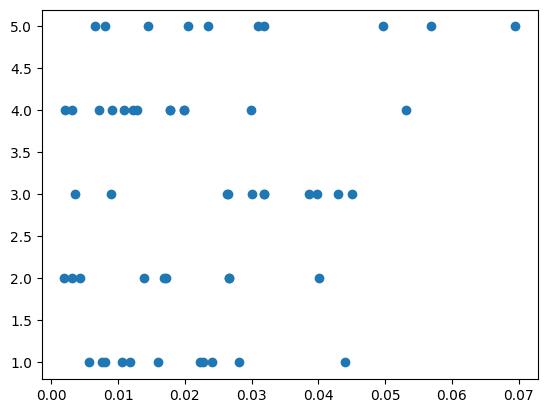

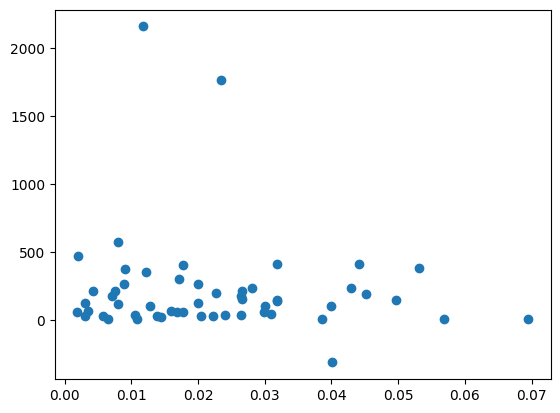

(array([32.88296406, 24.66222305, 21.92197604, 24.66222305, 16.44148203,
         8.22074102,  8.22074102,  5.48049401,  2.74024701,  2.74024701]),
 array([0.00192074, 0.00867871, 0.01543669, 0.02219466, 0.02895264,
        0.03571061, 0.04246858, 0.04922656, 0.05598453, 0.06274251,
        0.06950048]),
 <BarContainer object of 10 artists>)

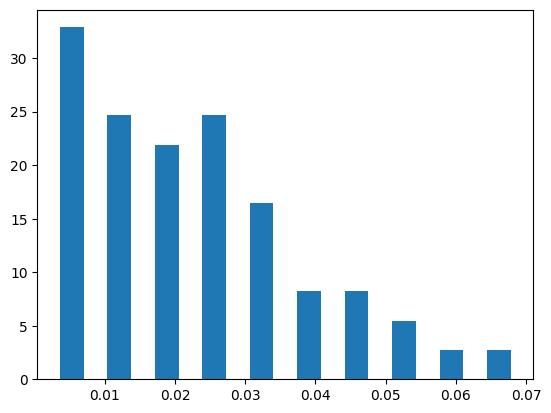

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.scatter(dfstat['ahp'], dfstat['grdp'])
plt.show()
plt.scatter(dfstat['ahp'], dfstat['days'].dt.days.astype('int16'))
plt.show()
plt.hist(dfstat['ahp'],bins=10, density=True, rwidth = 0.5)





In [97]:
analyze =pd.DataFrame(columns=['ahp','grdp','days'])
analyze['days'] =  dfstat['days'].dt.days.astype('int')
analyze['grdp'] =  dfstat['grdp'].astype('int')
analyze['ahp'] =  dfstat['ahp'].astype('float')
print(analyze.dtypes)
print(analyze.head())
cormat = analyze.corr()
round(cormat,2)
sns.heatmap(cormat);

AttributeError: Can only use .dt accessor with datetimelike values